# Image Fill by AutoEncoder

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import tensorflow as tf
import math
from sklearn import model_selection
import keras

from keras import layers
from keras import models
from keras import Model
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
from keras import optimizers

K.tensorflow_backend._get_available_gpus()
# The Function used to plot the original image and the predicted image 
def Plot_Img(n,images,fig_w,fig_h):
    # n is how many digits we will display//
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i])

import random
# The Function used to remove the middle square of the image
def Img_incomp_rand(imgs,cond,w=12):
    n = imgs.shape[0]
    for i in range(n):
        start = random.randint(0,31-w)
        end = start+w
        imgs[i][start:end,start:end,:] = 0
        cond[i][start:end,start:end,:] = 0
    return imgs,cond  
  
h_dim = 1024
batch_size = 50
height = 32
width = 32
channels = 3

Using TensorFlow backend.


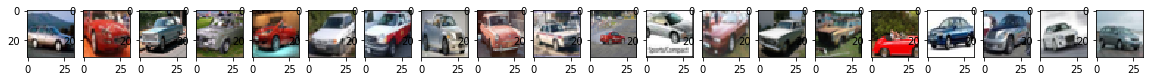

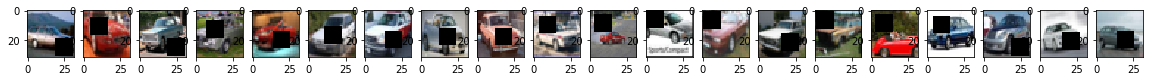

In [0]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 1]
x_test = x_test[y_test.flatten() == 1]

# Normalize the pixels to 0 and 1 range
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

(x_tra,y_tra),(x_te,y_te) = keras.datasets.cifar10.load_data()
x_tra = x_tra[y_tra.flatten() == 1]
x_te = x_te[y_te.flatten() == 1]

# Normalize the pixels to 0 and 1 range
x_tra = x_tra.astype('float32') / 255.
x_te = x_te.astype('float32') / 255.

cond_train = np.ones((x_train.shape[0],32,32,1))
cond_test = np.ones((x_test.shape[0],32,32,1))
# Modfied training and testing imgs
x_train,cond_train = Img_incomp_rand(x_train,cond_train)
x_test,cond_test = Img_incomp_rand(x_test,cond_test)

# Plot some examples
Plot_Img(20,x_tra,20,10)
Plot_Img(20,x_train,20,10)
plt.show()

## AutoEncoder to reconsturct the whole image

In [0]:
# Input
input1 = layers.Input(batch_shape=(batch_size,height,width,channels))
input2 = layers.Input(batch_shape=(batch_size,height,width,1))
full_Input = layers.concatenate([input1,input2], axis=-1)

# Encoder
full_l1 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(full_Input)
full_l1 = layers.BatchNormalization()(full_l1)
full_l2 = layers.Conv2D(64,(3,3),activation='relu',strides=2,padding='same')(full_l1)
full_l2 = layers.BatchNormalization()(full_l2)
full_l3 = layers.Conv2D(128,(3,3),activation='relu',strides=2,padding='same')(full_l2)
full_l3 = layers.BatchNormalization()(full_l3)
full_l4 = layers.Conv2D(256,(3,3),activation='relu',strides=2,padding='same')(full_l3)
#full_l4 = layers.BatchNormalization()(full_l4)
#full_l5 = layers.Conv2D(h_dim,(3,3),activation='relu',strides=2,padding='same')(full_l4)
full_encoder = Model([input1,input2],full_l4)


# Decoder
full_d1 = layers.Conv2DTranspose(256,(3,3),activation='relu',strides=2,padding='same')(full_l4)
full_d2 = layers.Conv2DTranspose(128,(3,3),activation='relu',strides=2,padding='same')(full_d1)
full_d3 = layers.Conv2DTranspose(64,(3,3),activation='relu',strides=2,padding='same')(full_d2)
#full_d4 = layers.Conv2DTranspose(64,(3,3),activation='relu',strides=2,padding='same')(full_d3)
full_d5 = layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')(full_d3)
full_ae = Model([input1,input2],full_d5)
full_ae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (50, 32, 32, 3)      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (50, 32, 32, 1)      0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (50, 32, 32, 4)      0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (50, 32, 32, 32)     1184        concatenate_3[0][0]              
__________

In [0]:
full_ae_opt = optimizers.Adam(0.0005,0.5)
full_ae.compile(optimizer=full_ae_opt, loss='mean_squared_error')
full_ae.fit([x_train,cond_train],x_tra,epochs=100,batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
5000/5000 [==============================] - 4s 823us/step - loss: 0.0255
Epoch 2/100
5000/5000 [==============================] - 2s 308us/step - loss: 0.0121
Epoch 3/100
5000/5000 [==============================] - 2s 305us/step - loss: 0.0103
Epoch 4/100
5000/5000 [==============================] - 2s 305us/step - loss: 0.0091
Epoch 5/100
5000/5000 [==============================] - 2s 305us/step - loss: 0.0083
Epoch 6/100
5000/5000 [==============================] - 2s 307us/step - loss: 0.0077
Epoch 7/100
5000/5000 [==============================] - 2s 306us/step - loss: 0.0073
Epoch 8/100
5000/5000 [==============================] - 2s 305us/step - loss: 0.0069
Epoch 9/100
5000/5000 [==============================] - 2s 307us/step - loss: 0.0068
Epoch 10/100
5000/5000 [==============================] - 2s 306us/step - loss: 0.0064
Epoch 11/100
5000/5000 [==============================] - 2s 309us/step - loss: 0.0061
Epoc

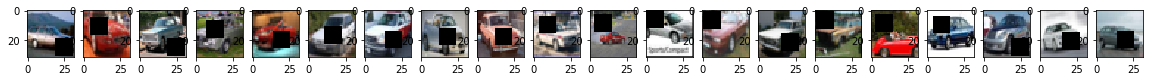

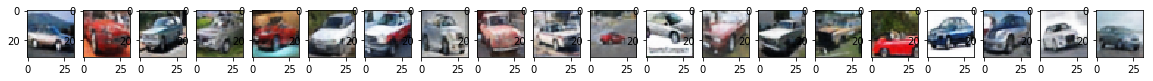

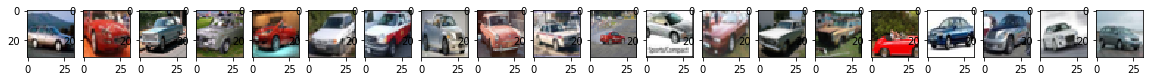

In [0]:
full_fill_train = full_ae.predict([x_train,cond_train],batch_size=batch_size)
Plot_Img(20,x_train,20,10)
Plot_Img(20,full_fill_train,20,10)
Plot_Img(20,x_tra,20,10)
plt.show()

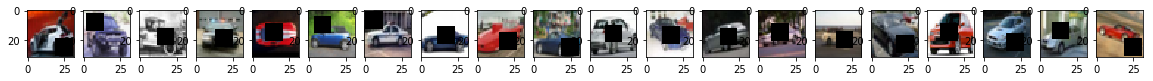

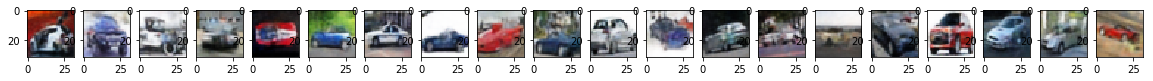

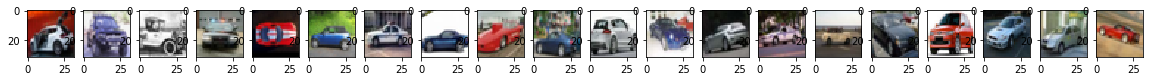

In [0]:
full_fill_test = full_ae.predict([x_test,cond_test],batch_size=batch_size)
Plot_Img(20,x_test,20,10)
Plot_Img(20,full_fill_test,20,10)
Plot_Img(20,x_te,20,10)
plt.show()

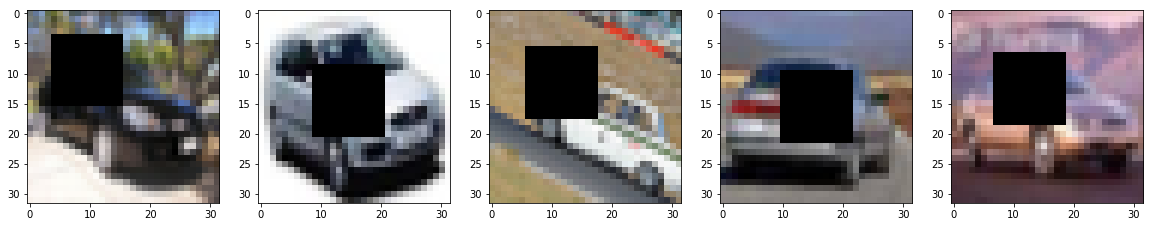

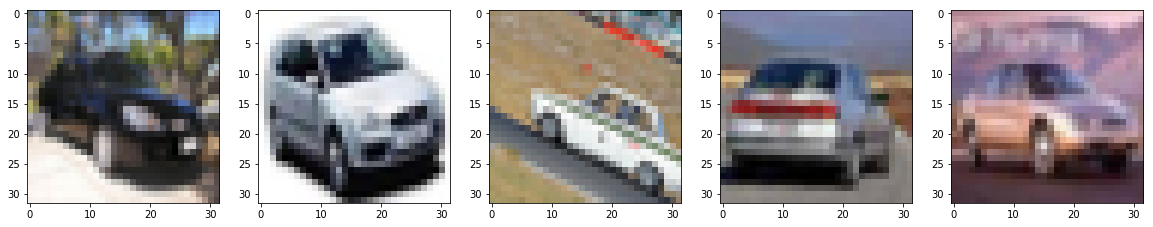

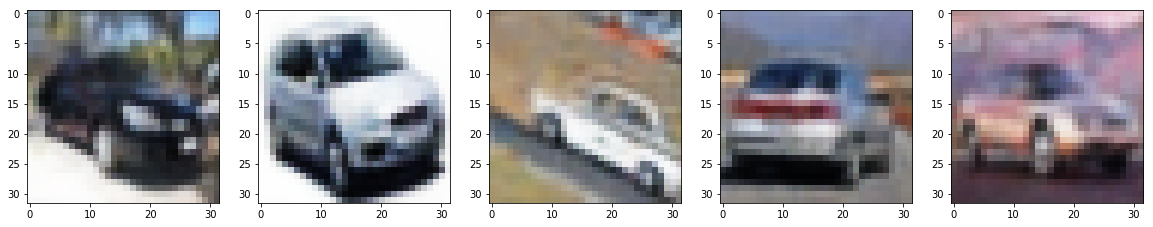

In [0]:
Plot_Img(5,x_train[30:35],20,10)
Plot_Img(5,x_tra[30:35],20,10)
Plot_Img(5,full_fill_train[30:35],20,10)

In [0]:
sqerror = []
for i in range(1000):
  sqerror.append(np.sum((full_fill_test[i]-x_te[i])**2))
sqerror = np.array(sqerror)

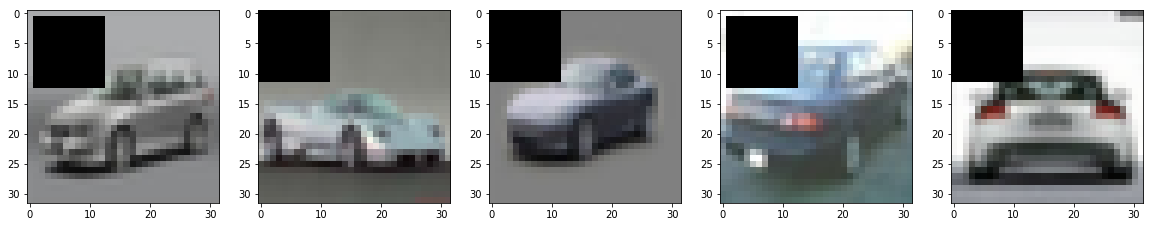

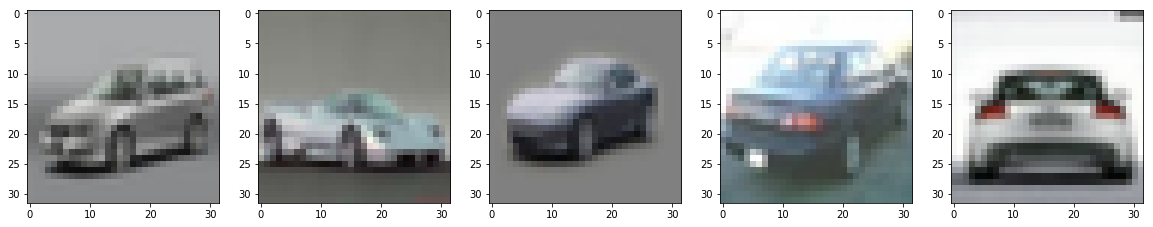

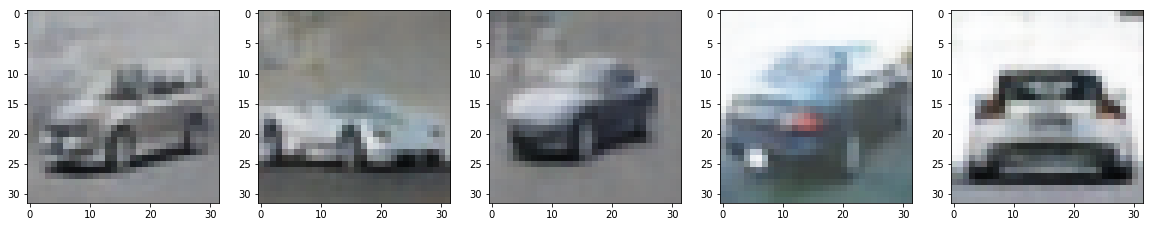

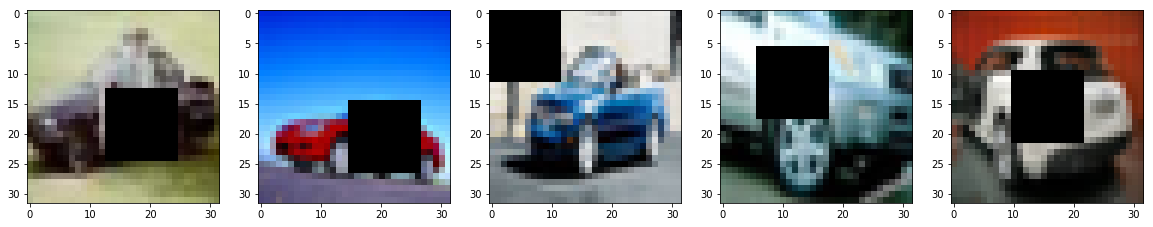

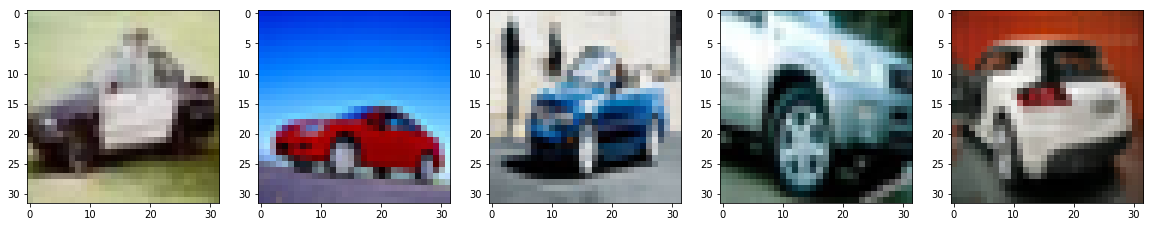

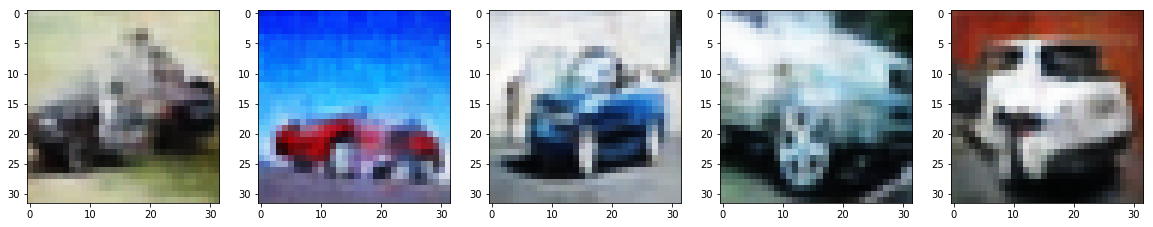

In [0]:
first_5 = np.argsort(sqerror)[0:5]
last_5 = np.argsort(sqerror)[995:1000]

Plot_Img(5,x_test[first_5],20,10)
Plot_Img(5,x_te[first_5],20,10)
Plot_Img(5,full_fill_test[first_5],20,10)

Plot_Img(5,x_test[last_5],20,10)
Plot_Img(5,x_te[last_5],20,10)
Plot_Img(5,full_fill_test[last_5],20,10)

## AutoEncoder to reconstruct the missing patches

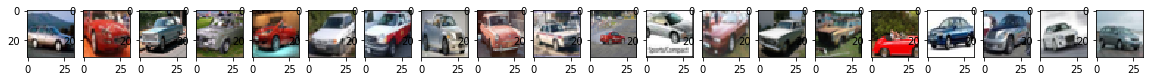

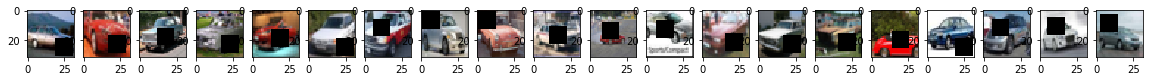

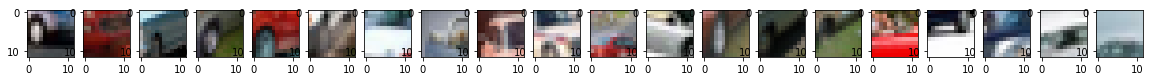

In [0]:
import random
# The Function used to remove the middle square of the image
def Img_incomp_rand_patches(imgs_mod,imgs,cond,w=12):
    n = imgs.shape[0]
    patches = []
    for i in range(n):
        start = random.randint(0,31-w)
        end = start+w
        imgs_mod[i][start:end,start:end,:] = 0
        cond[i][start:end,start:end,:] = 0
        patches.append(imgs[i][start:end,start:end,:])
    return imgs_mod,cond,patches

# Reload the dataset
(x_train2,y_train2),(x_test2,y_test2) = keras.datasets.cifar10.load_data()
x_train2 = x_train2[y_train2.flatten() == 1]
x_test2 = x_test2[y_test2.flatten() == 1]

cond_train2 = np.ones((x_tra.shape[0],32,32,1))
cond_test2 = np.ones((x_te.shape[0],32,32,1))

# Normalize the pixels to 0 and 1 range
x_train2 = x_train2.astype('float32') / 255.
x_test2 = x_test2.astype('float32') / 255.

# Modfied training and testing imgs
x_train2,cond_train2,x_train_patches2 = Img_incomp_rand_patches(x_train2,x_tra,cond_train2)
x_test2,cond_test2,x_test_patches2 = Img_incomp_rand_patches(x_test2,x_te,cond_test2)
x_train_patches2 = np.array(x_train_patches2)
x_test_patches2 = np.array(x_test_patches2)

# Plot some examples
Plot_Img(20,x_tra,20,10)
Plot_Img(20,x_train2,20,10)
Plot_Img(20,x_train_patches2,20,10)
plt.show()

In [0]:
# Input
input2_1 = layers.Input(batch_shape=(batch_size,height,width,channels))
input2_2 = layers.Input(batch_shape=(batch_size,height,width,1))
Input2 = layers.concatenate([input2_1,input2_2], axis=-1)

# Encoder
l1 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(Input2)
l1 = layers.BatchNormalization()(l1)
l2 = layers.Conv2D(64,(3,3),activation='relu',strides=2,padding='same')(l1)
l2 = layers.BatchNormalization()(l2)
l3 = layers.Conv2D(128,(3,3),activation='relu',strides=2,padding='same')(l2)
l3 = layers.BatchNormalization()(l3)
l4 = layers.Conv2D(256,(3,3),activation='relu',strides=2,padding='same')(l3)
l4 = layers.BatchNormalization()(l4)
l5 = layers.Conv2D(h_dim,(3,3),activation='relu',strides=2)(l4)
encoder = Model([input2_1,input2_2],l5)

# Decoder
d1 = layers.Conv2DTranspose(256,(3,3),activation='relu',strides=4)(l5)
d2 = layers.Conv2DTranspose(128,(3,3),activation='relu',strides=2,padding='same')(d1)
d3 = layers.Conv2DTranspose(64,(3,3),activation='relu')(d2)
d4 = layers.Conv2DTranspose(64,(3,3),activation='relu')(d3)
d5 = layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')(d4)
ae = Model([input2_1,input2_2],d5)
ae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (50, 32, 32, 3)      0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (50, 32, 32, 1)      0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (50, 32, 32, 4)      0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (50, 32, 32, 32)     1184        concatenate_4[0][0]              
__________

In [0]:
ae_opt = optimizers.Adam(0.0005,0.5)
ae.compile(optimizer=ae_opt, loss='mean_squared_error')
ae.fit([x_train2,cond_train2],x_train_patches2,epochs=200,batch_size=batch_size)

Epoch 1/200
5000/5000 [==============================] - 3s 681us/step - loss: 0.0500
Epoch 2/200
5000/5000 [==============================] - 2s 401us/step - loss: 0.0345
Epoch 3/200
5000/5000 [==============================] - 2s 399us/step - loss: 0.0300
Epoch 4/200
5000/5000 [==============================] - 2s 399us/step - loss: 0.0270
Epoch 5/200
5000/5000 [==============================] - 2s 406us/step - loss: 0.0243
Epoch 6/200
5000/5000 [==============================] - 2s 400us/step - loss: 0.0214
Epoch 7/200
5000/5000 [==============================] - 2s 408us/step - loss: 0.0192
Epoch 8/200
5000/5000 [==============================] - 2s 407us/step - loss: 0.0173
Epoch 9/200
5000/5000 [==============================] - 2s 406us/step - loss: 0.0156
Epoch 10/200
5000/5000 [==============================] - 2s 404us/step - loss: 0.0142
Epoch 11/200
5000/5000 [==============================] - 2s 405us/step - loss: 0.0130
Epoch 12/200
5000/5000 [============================

In [0]:
fill_train = ae.predict([x_train2,cond_train2],batch_size=batch_size)
fill_x_train = []
for i,condm in enumerate(cond_train2):
  a = np.zeros((32,32,3))
  b = np.zeros((32,32,3))
  b[:,:,0] = condm.reshape((32,32))
  b[:,:,1] = condm.reshape((32,32))
  b[:,:,2] = condm.reshape((32,32))
  a[np.where(b == 0)] = fill_train[i,:,:,:].reshape((12*12*3,))
  fill_x_train.append(x_train2[i]+a)
fill_x_train = np.array(fill_x_train)

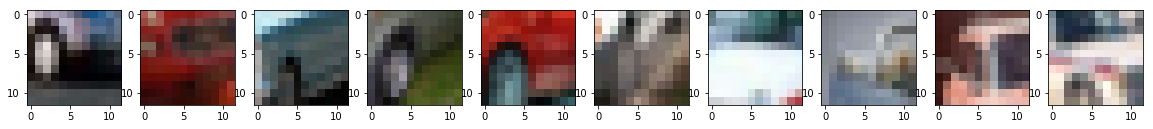

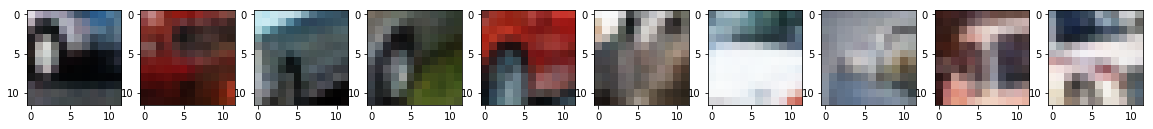

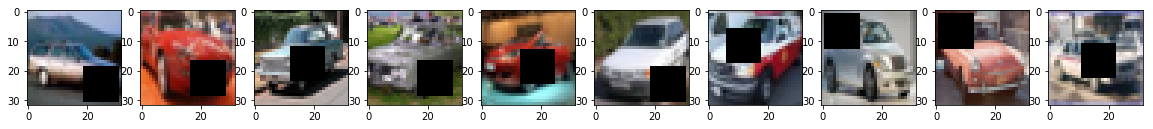

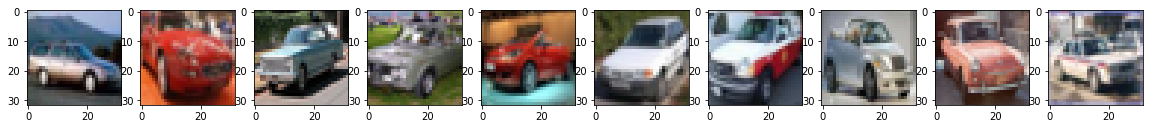

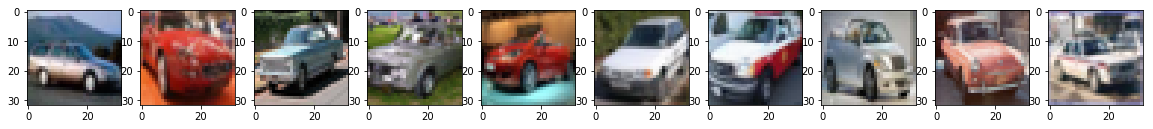

In [0]:
Plot_Img(10,x_train_patches2,20,10)
Plot_Img(10,fill_train,20,10)
Plot_Img(10,x_train2,20,10)
Plot_Img(10,x_tra,20,10)
Plot_Img(10,fill_x_train,20,10)
plt.show()

In [0]:
fill_test = ae.predict([x_test2,cond_test2],batch_size=batch_size)
fill_x_test = []
for i,condm in enumerate(cond_test2):
  a = np.zeros((32,32,3))
  b = np.zeros((32,32,3))
  b[:,:,0] = condm.reshape((32,32))
  b[:,:,1] = condm.reshape((32,32))
  b[:,:,2] = condm.reshape((32,32))
  a[np.where(b == 0)] = fill_test[i,:,:,:].reshape((12*12*3,))
  fill_x_test.append(x_test2[i]+a)
fill_x_test = np.array(fill_x_test)

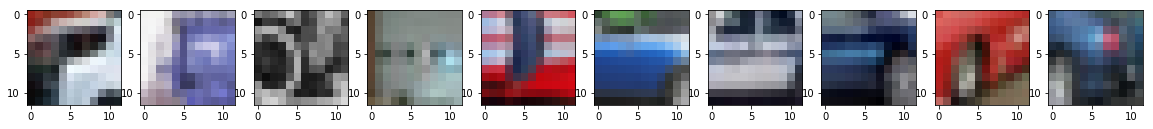

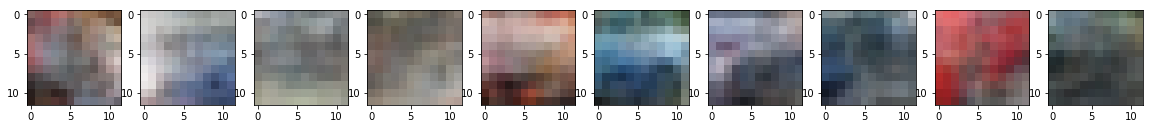

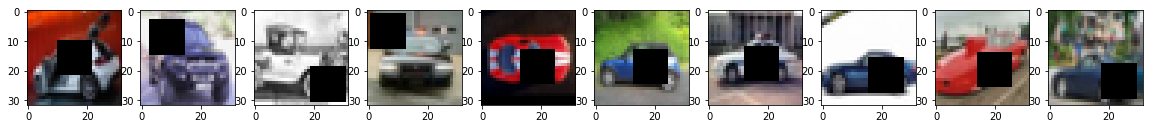

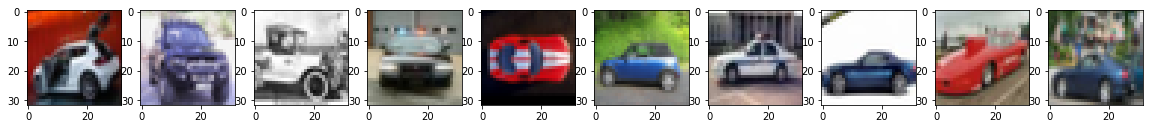

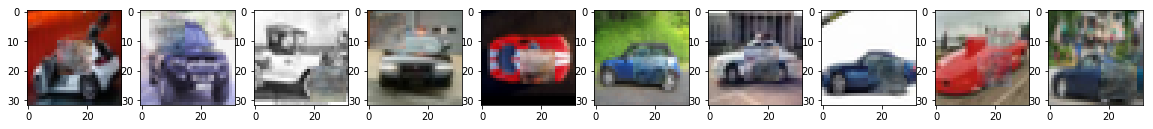

In [0]:
Plot_Img(10,x_test_patches2,20,10)
Plot_Img(10,fill_test,20,10)
Plot_Img(10,x_test2,20,10)
Plot_Img(10,x_te,20,10)
Plot_Img(10,fill_x_test,20,10)
plt.show()

Customize the loss function to predict a bigger patch and add strong penalty to the overlapped region

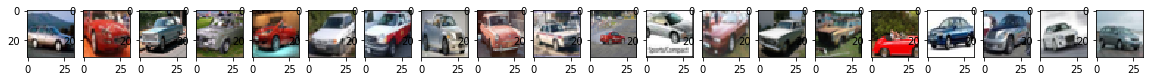

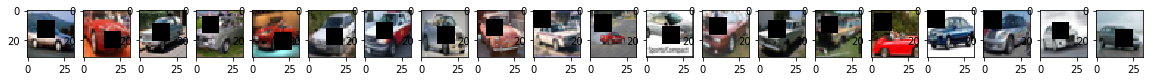

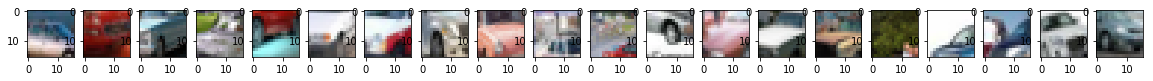

In [0]:
import random
# The Function used to remove the middle square of the image
def Img_incomp_rand_patches2(imgs_mod,imgs,cond,w=12):
    n = imgs.shape[0]
    patches = []
    for i in range(n):
        start = random.randint(0,31-w-4)
        end = start+w
        imgs_mod[i][start:end,start:end,:] = 0
        cond[i][start:end,start:end,:] = 0
        patches.append(imgs[i][start:(end+4),start:(end+4),:])
    return imgs_mod,cond,patches

# Reload the dataset
(x_train3,y_train3),(x_test3,y_test3) = keras.datasets.cifar10.load_data()
x_train3 = x_train3[y_train3.flatten() == 1]
x_test3 = x_test3[y_test3.flatten() == 1]

cond_train3 = np.ones((x_tra.shape[0],32,32,1))
cond_test3 = np.ones((x_te.shape[0],32,32,1))

# Normalize the pixels to 0 and 1 range
x_train3 = x_train3.astype('float32') / 255.
x_test3 = x_test3.astype('float32') / 255.

# Modfied training and testing imgs
x_train3,cond_train3,x_train_patches3 = Img_incomp_rand_patches2(x_train3,x_tra,cond_train3)
x_test3,cond_test3,x_test_patches3 = Img_incomp_rand_patches2(x_test3,x_te,cond_test3)
x_train_patches3 = np.array(x_train_patches3)
x_test_patches3 = np.array(x_test_patches3)

# Plot some examples
Plot_Img(20,x_tra,20,10)
Plot_Img(20,x_train3,20,10)
Plot_Img(20,x_train_patches3,20,10)
plt.show()

In [0]:
p_map_train = np.ones((x_tra.shape[0],16,16,1)) * 3
p_map_test = np.ones((x_tra.shape[0],16,16,1)) * 3
p_map_train[:,2:14,2:14,:] = p_map_train[:,2:14,2:14,:] - 1
p_map_test[:,2:14,2:14,:] = p_map_train[:,2:14,2:14,:] - 1
p_map_train[:,1:15,1:15,:] = p_map_train[:,1:15,1:15,:] - 1
p_map_test[:,1:15,1:15,:] = p_map_train[:,1:15,1:15,:] - 1

In [0]:
# Customized loss fucntion to penalize the boundary more
def patches_loss(pred_patch,patch):
  loss = K.mean(K.square(pred_patch-patch)*weight_map)
  return loss

In [0]:
# Input
p_input1 = layers.Input(batch_shape=(batch_size,height,width,channels))
p_input2 = layers.Input(batch_shape=(batch_size,height,width,1))
weight_map = layers.Input(batch_shape=(batch_size,16,16,1))
p_Input = layers.concatenate([p_input1,p_input2], axis=-1)

# Encoder
p_l1 = layers.Conv2D(32,(3,3),activation='relu',padding='same')(p_Input)
p_l1 = layers.BatchNormalization()(p_l1)
p_l2 = layers.Conv2D(64,(3,3),activation='relu',strides=2,padding='same')(p_l1)
p_l2 = layers.BatchNormalization()(p_l2)
p_l3 = layers.Conv2D(128,(3,3),activation='relu',strides=2,padding='same')(p_l2)
p_l3 = layers.BatchNormalization()(p_l3)
p_l4 = layers.Conv2D(256,(3,3),activation='relu',strides=2,padding='same')(p_l3)
p_l4 = layers.BatchNormalization()(p_l4)
p_l5 = layers.Conv2D(h_dim,(3,3),activation='relu',strides=2)(p_l4)
p_encoder = Model([p_input1,p_input2,weight_map],p_l5)

# Decoder
p_d1 = layers.Conv2DTranspose(256,(3,3),activation='relu',strides=4)(p_l5)
p_d2 = layers.Conv2DTranspose(128,(3,3),activation='relu',strides=2,padding='same')(p_d1)
p_d3 = layers.Conv2DTranspose(64,(3,3),activation='relu')(p_d2)
p_d4 = layers.Conv2DTranspose(64,(3,3),activation='relu')(p_d3)
p_d5 = layers.Conv2DTranspose(64,(3,3),activation='relu')(p_d4)
p_d6 = layers.Conv2DTranspose(64,(3,3),activation='relu')(p_d5)
p_d7 = layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')(p_d6)
p_ae = Model([p_input1,p_input2,weight_map],p_d7)
p_ae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (50, 32, 32, 3)      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (50, 32, 32, 1)      0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (50, 32, 32, 4)      0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (50, 32, 32, 32)     1184        concatenate_3[0][0]              
__________

In [0]:
p_ae_opt = optimizers.Adam(0.0005,0.5)
p_ae.compile(optimizer=p_ae_opt, loss=patches_loss)
p_ae.fit([x_train3,cond_train3,p_map_train],x_train_patches3,epochs=200,batch_size=batch_size)

Epoch 1/200
5000/5000 [==============================] - 4s 761us/step - loss: 0.0868
Epoch 2/200
5000/5000 [==============================] - 2s 459us/step - loss: 0.0585
Epoch 3/200
5000/5000 [==============================] - 2s 457us/step - loss: 0.0514
Epoch 4/200
5000/5000 [==============================] - 2s 460us/step - loss: 0.0483
Epoch 5/200
5000/5000 [==============================] - 2s 467us/step - loss: 0.0451
Epoch 6/200
5000/5000 [==============================] - 2s 483us/step - loss: 0.0426
Epoch 7/200
5000/5000 [==============================] - 2s 465us/step - loss: 0.0409
Epoch 8/200
5000/5000 [==============================] - 2s 470us/step - loss: 0.0393
Epoch 9/200
5000/5000 [==============================] - 2s 470us/step - loss: 0.0378
Epoch 10/200
5000/5000 [==============================] - 2s 470us/step - loss: 0.0355
Epoch 11/200
5000/5000 [==============================] - 2s 471us/step - loss: 0.0329
Epoch 12/200
5000/5000 [============================

In [0]:
fill_train_larger = p_ae.predict([x_train3,cond_train3,p_map_train],batch_size=batch_size)
fill_x_train_larger = []
for i,condm in enumerate(cond_train3):
  a = np.zeros((32,32,3))
  b = np.zeros((32,32,3))
  b[:,:,0] = condm.reshape((32,32))
  b[:,:,1] = condm.reshape((32,32))
  b[:,:,2] = condm.reshape((32,32))
  a[np.where(b == 0)] = fill_train_larger[i,2:14,2:14,:].reshape((12*12*3,))
  fill_x_train_larger.append(x_train3[i]+a)
fill_x_train_larger = np.array(fill_x_train_larger)

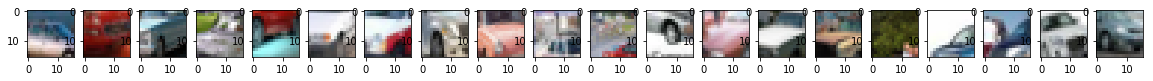

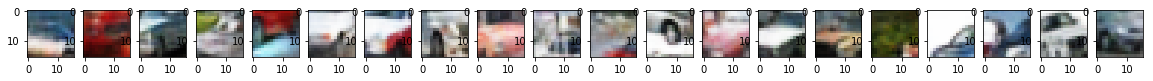

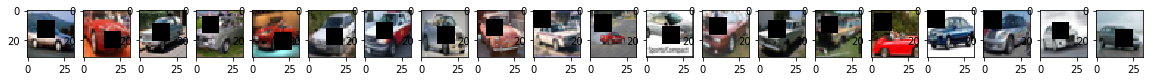

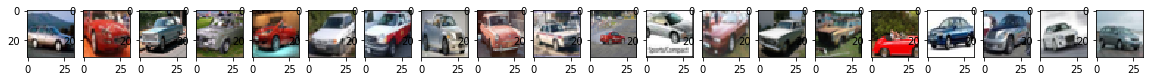

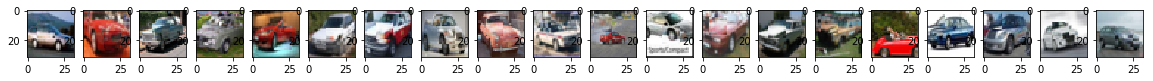

In [0]:
Plot_Img(20,x_train_patches3,20,10)
Plot_Img(20,fill_train_larger,20,10)
Plot_Img(20,x_train3,20,10)
Plot_Img(20,x_tra,20,10)
Plot_Img(20,fill_x_train_larger,20,10)
plt.show()

In [0]:
fill_test_larger = p_ae.predict([x_test3,cond_test3,p_map_test],batch_size=batch_size)
fill_x_test_larger = []
for i,condm in enumerate(cond_test3):
  a = np.zeros((32,32,3))
  b = np.zeros((32,32,3))
  b[:,:,0] = condm.reshape((32,32))
  b[:,:,1] = condm.reshape((32,32))
  b[:,:,2] = condm.reshape((32,32))
  a[np.where(b == 0)] = fill_test_larger[i,2:14,2:14,:].reshape((12*12*3,))
  fill_x_test_larger.append(x_test3[i]+a)
fill_x_test_larger = np.array(fill_x_test_larger)

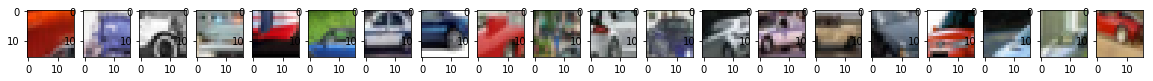

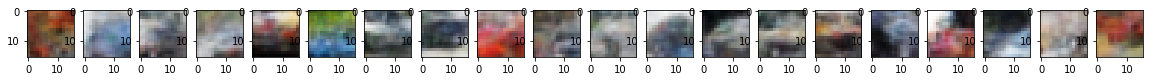

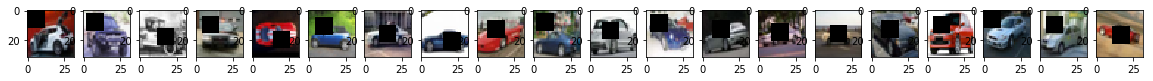

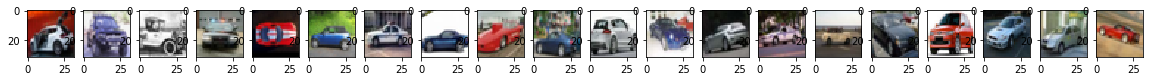

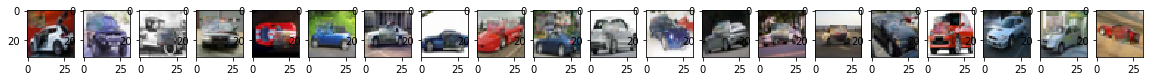

In [0]:
Plot_Img(20,x_test_patches3,20,10)
Plot_Img(20,fill_test_larger,20,10)
Plot_Img(20,x_test3,20,10)
Plot_Img(20,x_te,20,10)
Plot_Img(20,fill_x_test_larger,20,10)
plt.show()